In [1]:
import numpy as np
import scipy as sp
from scipy.special import binom
import matplotlib.pyplot as plt
import plotly
import pandas as pd
import mpnum as mp
import sklearn
import plotly.offline as ply
from sklearn import svm
from numba import autojit

<IPython.core.display.Javascript object>


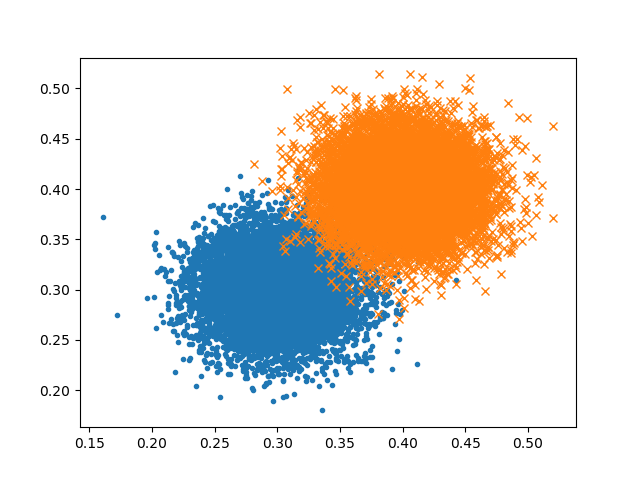

In [2]:
%matplotlib notebook
#Generiamo il toy model.. Sampling da due gaussiane 2d overlappate
mean1=[0.3,0.3]
cov1=[[0.001,0],[0,0.001]]
mean2=[0.4,0.4]
cov2=[[0.001,0],[0,0.001]]
data1=np.random.multivariate_normal(mean1, cov1, 10000)
data2=np.random.multivariate_normal(mean2, cov2, 10000)
data1_x=data1.T[0]
data1_y=data1.T[1]
data2_x=data2.T[0]
data2_y=data2.T[1]
f1=plt.figure()
plt.plot(data1_x,data1_y,".")
plt.plot(data2_x,data2_y,"x")
plt.show()

label1=np.array([0]*len(data1))
label2=np.array([1]*len(data2))
label=np.concatenate([label1,label2])
data=np.concatenate([data1,data2])


Classical support vector machine for classification

In [3]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function(np.c_[xi.ravel(), yj.ravel()])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

In [4]:

#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create SVM classification object 
model = svm.SVC(kernel='linear', C=4, gamma=1) 
# there is various option associated with it, like changing kernel, gamma and C value. Will discuss more # about it in next section.Train the model using the training sets and check score
model.fit(data, label)
model.score(data, label)
#Predict Output
data3=np.random.multivariate_normal(mean1, cov1, 100000)
data4=np.random.multivariate_normal(mean2, cov2, 100000)
predicted=model.predict(data3)

<IPython.core.display.Javascript object>


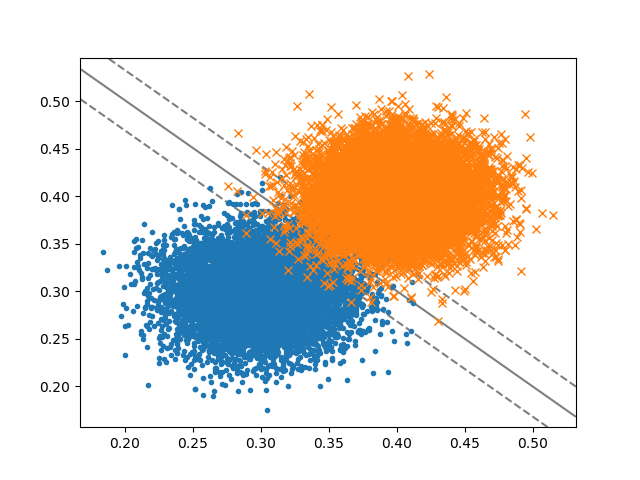

In [19]:
plt.plot(data1_x,data1_y,".",label="gaus1")
plt.plot(data2_x,data2_y,"x",label="gaus2")
plot_svc_decision_function(model)
plt.show()

In [6]:
np.sum(predicted)

1239

## Iniziamo con Tensor Networks

Prepariamo i dati

In [7]:
@autojit
def feature_map(x):
    return(np.array([np.cos(x*np.pi/2.),np.sin(x*np.pi/2.)]))
@autojit
def delta(x,y):
    if(x == y ):
        delta=1
    else:
        delta=0
    return delta

def train(data,label,weight,l):
    kdelta=0
    j=l
    for i in range(0,len(data)):
        coeff_temp=0
        kdelta=delta(label[i],j)
        #print(label[i])
        x_mpa = mp.MPArray.from_array(feature_map(data[i][0]), plegs=1)
        y_mpa = mp.MPArray.from_array(feature_map(data[i][1]), plegs=1)
        f=mp.dot(weight,y_mpa)
        f=mp.dot(f,x_mpa)
        coeff_temp=(kdelta-f.to_array())
        big_data= mp.MPArray.from_kron([feature_map(data[i][0]),feature_map(data[i][1])])
        big_data=big_data.group_sites(2)
        
        if i is 0:
            temp=coeff_temp*big_data
        else:
            temp=temp+(coeff_temp*big_data)
    return temp
@autojit
def decide(w_class0,w_class1,x,y):
    x_mpa = mp.MPArray.from_array(feature_map(x), plegs=1)
    y_mpa = mp.MPArray.from_array(feature_map(y), plegs=1)
    valuef0=mp.dot(w_class0,y_mpa)
    valuef0=mp.dot(valuef0,x_mpa)
    valuef1=mp.dot(w_class1,y_mpa)
    valuef1=mp.dot(valuef1,x_mpa)
    if(np.fabs(valuef0.to_array())>np.fabs(valuef1.to_array())):
        return 0
    else:
        return 1

In [8]:
#Cosi si creano gli array dei dati
mps = mp.MPArray.from_kron([feature_map(data3[0][0]), feature_map(data3[0][1])])
mps.to_array()

array([[ 0.78693985,  0.4110969 ],
       [ 0.407839  ,  0.21305485]])

In [9]:
#Creo un MPS con  l 
#                 |
#               (   )-(  )
#                 |    |
#           phi(x)   phi(y)

rng = np.random.RandomState(seed=43)
mpa = mp.random_mpa(sites=2, ldim=[[1,2],[2]], bdim=2, randstate=rng, normalized=True)

In [10]:
mpa2=mpa.group_sites(2)
mpa2.plegs

(3,)

In [11]:
learned0=train(np.concatenate([data1[0:10000],data2[0:10000]]),np.concatenate([label1[0:10000],label2[0:10000]]),mpa2,0)[0]
learned1=train(np.concatenate([data1[0:10000],data2[0:10000]]),np.concatenate([label1[0:10000],label2[0:10000]]),mpa2,1)[0]

In [12]:
classifydata3=[]
classifydata4=[]
for i in range(0,len(data3)):
    classifydata3.append(decide(learned0,learned1,data3[i][0],data3[i][1]))
    classifydata4.append(decide(learned0,learned1,data4[i][0],data4[i][1]))
classifydata3=np.array(classifydata3)
classifydata4=np.array(classifydata4)

In [13]:
def plot_tn_decision_function(wclass0,wclass1, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] =2*( decide(wclass0,wclass1,xi,yj)-0.5)
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

<IPython.core.display.Javascript object>


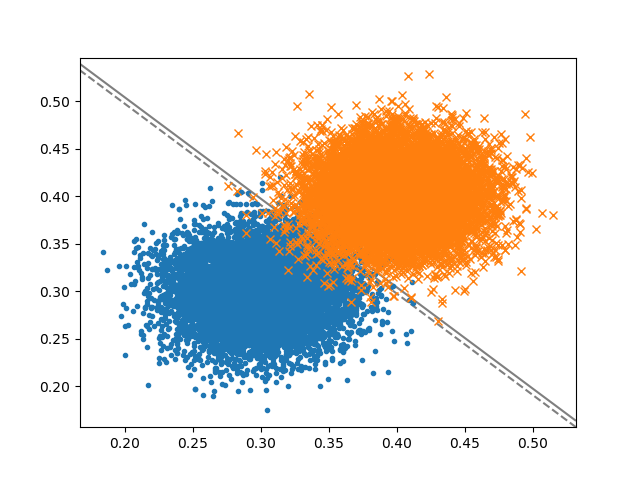

In [20]:
plt.plot(data1_x,data1_y,".",label="gaus1")
plt.plot(data2_x,data2_y,"x",label="gaus2")
plot_tn_decision_function(learned0,learned1, ax=None)
plt.show()

# Sweeeeeping!!

Define some parameters

In [3]:
d = 3    #local dimension of the feature map

Define Ausiliar functions

In [4]:
@autojit
def feature_map(x):
    """Local feature map"""
    
    x_arr = 0.5 * np.pi * np.array([x]*d)
    s = np.arange(d)
    return np.sqrt(binom([d-1]*d,s)) * np.power(np.cos(x_arr), d-1-s) * np.power(np.sin(x_arr), s)

@autojit
def Tdelta(l):
    """Create a tensor kronecker delta"""
    return mp.MPArray.from_kron([np.array([1-l,l])])

@autojit
def evaluate(Tweight, x, y):
    xy_mpa = mp.MPArray.from_kron([feature_map(x),feature_map(y)]).group_sites(2) # feature tensor
    Tf = mp.dot(Tweight,xy_mpa,axes=([1,2],[0,1]))
    W0 = mp.dot(Tf, Tdelta(0)).to_array()
    W1 = mp.dot(Tf, Tdelta(1)).to_array()
    Wdiff = W0 - W1
    Wsum = W0 + W1
    return Wdiff * Wsum / np.abs(Wdiff * Wsum)

def plot_tn_decision_function(Tweight, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 100)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] =evaluate(Tweight,xi,yj)
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

Define sweeping algorithm

In [5]:
@autojit
def update2sites(data, label, Tweight):    
    TdeltaB = mp.MPArray.from_kron([np.array([0]*2), np.array([0]*d), np.array([0]*d)]).group_sites(3) #null tensor deltaB (single size)
    for idx in range(len(data)):
        # create the full feature map
        xy_mpa = mp.MPArray.from_kron([feature_map(data[idx][0]),feature_map(data[idx][1])]).group_sites(2) # feature tensor
        # tensot product between the weights and the feature map
        Tf = mp.dot(Tweight,xy_mpa,axes=([1,2],[0,1])) # the last two physical legs are of Tweight are contracted with the feature tensor
        Tcoef = (Tdelta(label[idx]) - Tf)
        Ttemp = mp.MPArray.from_kron([Tcoef.to_array(), xy_mpa.to_array()]).group_sites(2)
        TdeltaB = TdeltaB + Ttemp
    
    Tweight = Tweight + alpha * TdeltaB
    return Tweight

# Classify data

## Two overlapping  gaussians

<IPython.core.display.Javascript object>


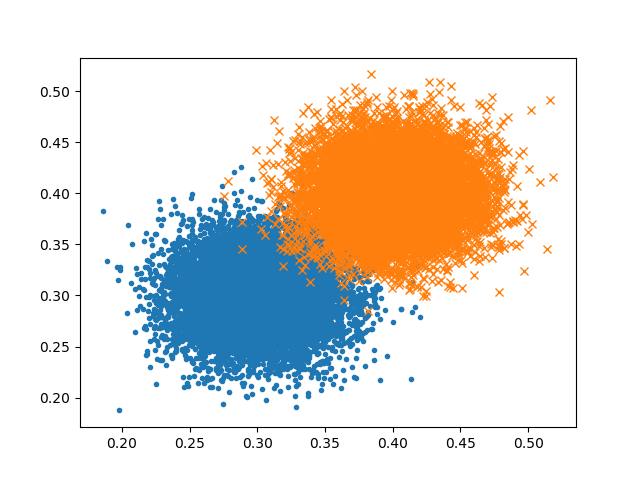

In [6]:
# Sampling da due gaussiane 2d overlappate
mean1=[0.3,0.3]
cov1=[[0.001,0],[0,0.001]]
mean2=[0.4,0.4]
cov2=[[0.001,0],[0,0.001]]
class0=np.random.multivariate_normal(mean1, cov1, 10000)
class1=np.random.multivariate_normal(mean2, cov2, 10000)

f1=plt.figure()
plt.plot(class0.T[0],class0.T[1],".")
plt.plot(class1.T[0],class1.T[1],"x")
plt.show()

Generate a random tensor weight and prepare training data

In [7]:
# generate Tensor weight
rng = np.random.RandomState(seed=143)
Tweight = mp.random_mpa(sites=1, ldim=[[2,d,d]], bdim=1, randstate=rng, normalized=True)

# set data
numdata = 1000
train_data = np.concatenate([class0[0:numdata], class1[0:numdata]])
label = np.concatenate([np.array([0]*numdata), np.array([1]*numdata)])

Update Tensor weight using gradient descent steps

In [9]:
numsteps = 100
alpha = 5e-4 # control convergence

for idx in range(numsteps):
    Tweight = update2sites(train_data, label, Tweight)

Plot results

<IPython.core.display.Javascript object>


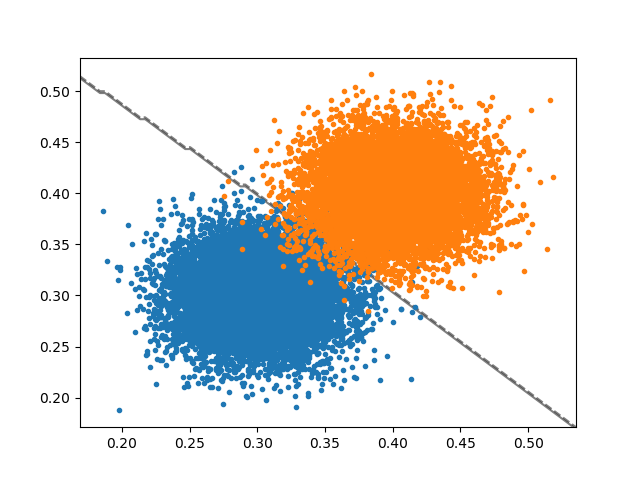

In [10]:
point_to_plot = 10000
plt.plot(class0[0:point_to_plot,0], class0[0:point_to_plot,1], '.')
plt.plot(class1[0:point_to_plot,0], class1[0:point_to_plot,1], '.')
plot_tn_decision_function(Tweight, ax=None)
plt.show()

## Semi circular uniform distributions

In [11]:
d = 3

<IPython.core.display.Javascript object>


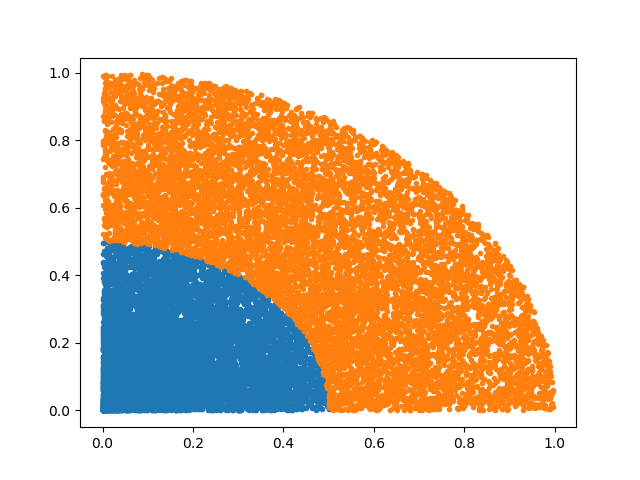

In [12]:
max_data = 10000
class0_radius = np.random.uniform(0, 0.5, max_data)
class0_phase = np.random.uniform(0, 0.5*np.pi, max_data)
class1_radius = np.random.uniform(0.5, 1, max_data)
class1_phase = np.random.uniform(0, 0.5*np.pi, max_data)

x0 = np.array([class0_radius*np.cos(class0_phase)])
y0 = np.array([class0_radius*np.sin(class0_phase)])
class0 = np.concatenate((x0.T, y0.T), axis=1)

x1 = np.array([class1_radius*np.cos(class1_phase)])
y1 = np.array([class1_radius*np.sin(class1_phase)])
class1 = np.concatenate((x1.T, y1.T), axis=1)

plt.plot(class0[:,0], class0[:,1], '.')
plt.plot(class1[:,0], class1[:,1], '.')
plt.show()

Generate a random tensor weight and prepare training data

In [13]:
# generate Tensor weight
rng = np.random.RandomState(seed=143)
Tweight = mp.random_mpa(sites=1, ldim=[[2,d,d]], bdim=1, randstate=rng, normalized=True)

# set data
numdata = 1000
train_data = np.concatenate([class0[0:numdata],class1[0:numdata]])
label = np.concatenate([np.array([0]*numdata),np.array([1]*numdata)])

Update Tensor weight using gradient descent steps

In [14]:
numsteps = 200
alpha = 1e-3 # control convergence

for idx in range(numsteps):
    Tweight = update2sites(train_data, label, Tweight)

Plot results

<IPython.core.display.Javascript object>


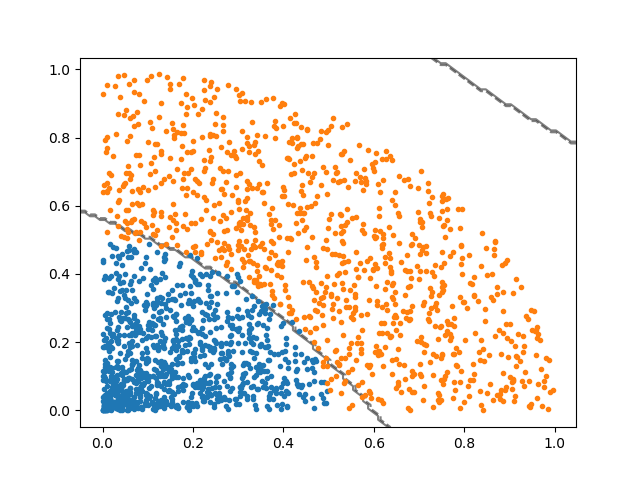

In [15]:
point_to_plot = 1000
plt.plot(class0[0:point_to_plot,0], class0[0:point_to_plot,1], '.')
plt.plot(class1[0:point_to_plot,0], class1[0:point_to_plot,1], '.')
plot_tn_decision_function(Tweight, ax=None)
plt.show()

## Circular distribution

In [16]:
d = 3

<IPython.core.display.Javascript object>


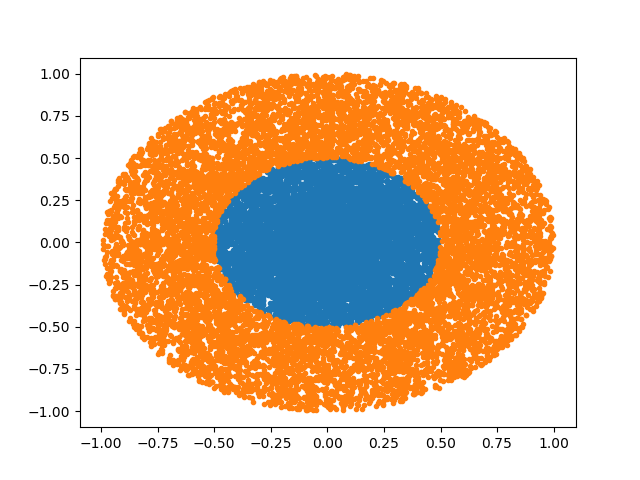

In [17]:
max_data = 10000
class0_radius = np.random.uniform(0, 0.5, max_data)
class0_phase = np.random.uniform(0, 2*np.pi, max_data)
class1_radius = np.random.uniform(0.5, 1, max_data)
class1_phase = np.random.uniform(0, 2*np.pi, max_data)

x0 = np.array([class0_radius*np.cos(class0_phase)])
y0 = np.array([class0_radius*np.sin(class0_phase)])
class0 = np.concatenate((x0.T, y0.T), axis=1)

x1 = np.array([class1_radius*np.cos(class1_phase)])
y1 = np.array([class1_radius*np.sin(class1_phase)])
class1 = np.concatenate((x1.T, y1.T), axis=1)

plt.plot(class0[:,0], class0[:,1], '.')
plt.plot(class1[:,0], class1[:,1], '.')
plt.show()

In [18]:
# generate Tensor weight
rng = np.random.RandomState(seed=143)
Tweight = mp.random_mpa(sites=1, ldim=[[2,d,d]], bdim=1, randstate=rng, normalized=True)

# set data
numdata = 1000
train_data = np.concatenate([class0[0:numdata],class1[0:numdata]])
label = np.concatenate([np.array([0]*numdata),np.array([1]*numdata)])

In [19]:
numsteps = 200
alpha = 1e-3 # control convergence

for idx in range(numsteps):
    Tweight = update2sites(train_data, label, Tweight)

<IPython.core.display.Javascript object>


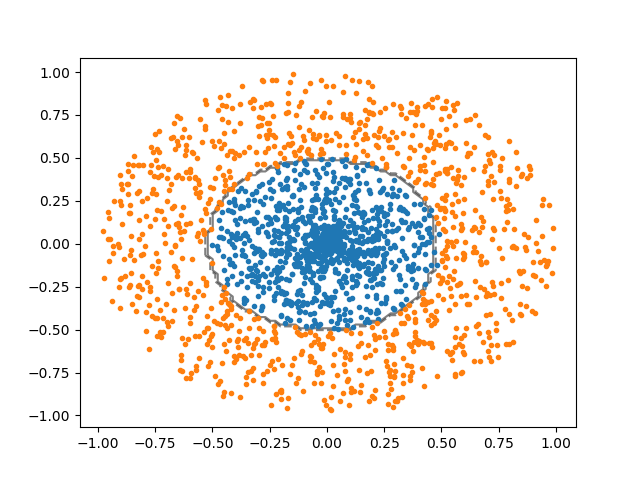

In [20]:
point_to_plot = 1000
plt.plot(class0[0:point_to_plot,0], class0[0:point_to_plot,1], '.')
plt.plot(class1[0:point_to_plot,0], class1[0:point_to_plot,1], '.')
plot_tn_decision_function(Tweight, ax=None)
plt.show()

## Spiral distributions

In [21]:
d = 10

<IPython.core.display.Javascript object>


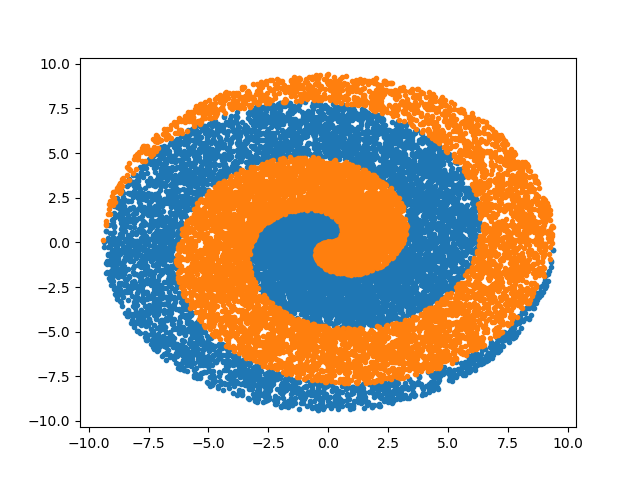

In [22]:
max_data = 10000
max_angle = 3*np.pi
theta = np.random.uniform(0, max_angle, max_data)

class0_phase = np.random.uniform(0, np.pi, max_data)
class1_phase = np.random.uniform(0, -np.pi, max_data)

x0 = np.array([theta * np.cos(theta + class0_phase)])
y0 = np.array([theta * np.sin(theta + class0_phase)])
class0 = np.concatenate((x0.T, y0.T), axis=1)

x1 = np.array([theta * np.cos(theta + class1_phase)])
y1 = np.array([theta * np.sin(theta + class1_phase)])
class1 = np.concatenate((x1.T, y1.T), axis=1)

plt.plot(class0[:,0], class0[:,1], '.')
plt.plot(class1[:,0], class1[:,1], '.')
plt.show()

In [23]:
# generate Tensor weight
rng = np.random.RandomState(seed=143)
Tweight = mp.random_mpa(sites=1, ldim=[[2,d,d]], bdim=1, randstate=rng, normalized=True)

# set data
numdata = 1000
train_data = np.concatenate([class0[0:numdata],class1[0:numdata]])
label = np.concatenate([np.array([0]*numdata),np.array([1]*numdata)])

In [25]:
numsteps = 1000
alpha = 1e-3 # control convergence

print('step: ', 0, ': ')
print(Tweight.to_array())
for idx in range(numsteps):
    Tweight = update2sites(train_data, label, Tweight)
    print('step: ', idx+1, ': ')
    print(Tweight.to_array())

step:  0 : 
[[[  3.19346214e-02   1.32298843e-01  -1.52274693e-01  -5.58798274e-02
     8.59197431e-02   1.67265113e-02  -2.24278209e-02  -3.07292573e-02
     1.41032264e-02  -3.47184188e-02]
  [ -2.67152033e-02   1.35839741e-02  -1.25916936e-01   6.01844759e-02
    -3.14397177e-02  -8.24470930e-03  -4.72687391e-02   2.60825635e-02
     3.81746352e-02  -8.11977639e-02]
  [  6.15831383e-02   1.70899541e-02  -1.02494615e-02   4.33059786e-02
     3.17116685e-02   2.95489288e-02  -1.13075780e-03   9.74321535e-02
     3.61629200e-03  -8.41054207e-02]
  [ -5.34322928e-02   3.92035997e-02   6.81738550e-02  -3.93558824e-02
     4.35036109e-02   9.30708333e-02  -3.11509189e-02  -9.09002917e-02
    -1.25713278e-01   4.91659241e-02]
  [  7.27921399e-02  -9.79104044e-02   7.38540561e-03  -7.68074012e-02
     1.02805390e-02   2.48778088e-02  -6.71388387e-02  -3.03290828e-02
    -1.20440317e-02  -5.78251807e-02]
  [ -8.34462292e-02  -6.85955810e-02   8.02354197e-02   2.42287334e-02
     1.07043851e-

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


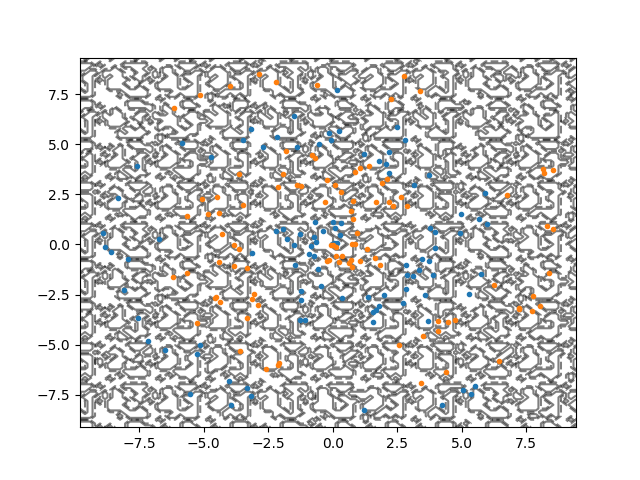

In [26]:
point_to_plot = 100
plt.plot(class0[0:point_to_plot,0], class0[0:point_to_plot,1], '.')
plt.plot(class1[0:point_to_plot,0], class1[0:point_to_plot,1], '.')
plot_tn_decision_function(Tweight, ax=None)
plt.show()